# Case Study A-Z: A Machine Learning powered Strategy (DNN)

_Disclaimer: <br>
The following illustrative example is for general information and educational purposes only. <br>
It is neither investment advice nor a recommendation to trade, invest or take whatsoever actions.<br>
The below code should only be used in combination with an Oanda/FXCM Practice/Demo Account and NOT with a Live Trading Account._

## Getting and Preparing the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from talib import abstract
import tpqoa
import fxcmpy
import time
import keras
import pickle
plt.style.use("seaborn")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/v20-3.0.25.0-py3.8.egg/v20/request.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/v20-3.0.25.0-py3.8.egg/v20/request.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
2023-06-01 22:02:55.220580: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 22:02:55.297787: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 22:02:55.298889: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 22:02:56.684200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [ ]:
data = pd.read_csv("DNN_data.csv", parse_dates = ["time"], index_col = "time")

In [ ]:
data 

,EUR_USD
time,
2017-01-02 23:20:00,1.04574
2017-01-02 23:40:00,1.04608
2017-01-03 00:00:00,1.04575
2017-01-03 00:20:00,1.04672
2017-01-03 00:40:00,1.04696
...,...
2019-12-30 23:00:00,1.12012
2019-12-30 23:20:00,1.12030
2019-12-30 23:40:00,1.12018


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55785 entries, 2017-01-02 23:20:00 to 2019-12-31 00:20:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  55785 non-null  float64
dtypes: float64(1)
memory usage: 871.6 KB


In [ ]:
symbol = data.columns[0]
symbol

'EUR_USD'

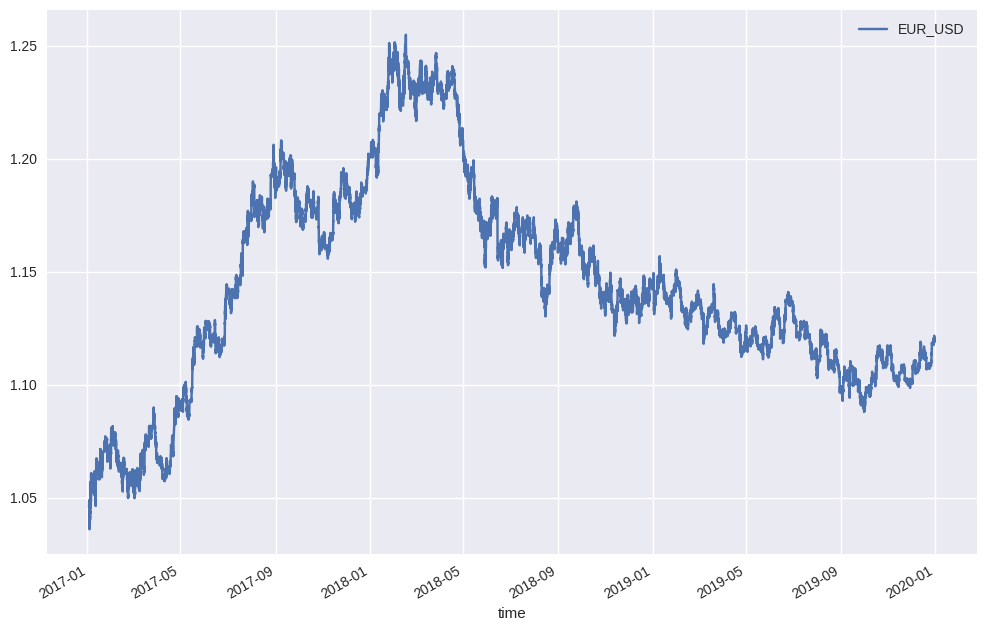

In [ ]:
data.plot(figsize = (12, 8))
plt.show()

In [ ]:
data["returns"] = np.log(data[symbol] / data[symbol].shift())

In [ ]:
data

,EUR_USD,returns
time,,
2017-01-02 23:20:00,1.04574,NaN
2017-01-02 23:40:00,1.04608,0.00033
2017-01-03 00:00:00,1.04575,-0.00032
2017-01-03 00:20:00,1.04672,0.00093
2017-01-03 00:40:00,1.04696,0.00023
...,...,...
2019-12-30 23:00:00,1.12012,0.00008
2019-12-30 23:20:00,1.12030,0.00016
2019-12-30 23:40:00,1.12018,-0.00011


## Adding Label/Features

In [ ]:
window = 50

In [ ]:
df = data.copy()
df["dir"] = np.where(df["returns"] > 0, 1, 0)
'''
df["sma"] = df[symbol].rolling(window).mean() - df[symbol].rolling(150).mean()
df["boll"] = (df[symbol] - df[symbol].rolling(window).mean()) / df[symbol].rolling(window).std()
df["min"] = df[symbol].rolling(window).min() / df[symbol] - 1
df["max"] = df[symbol].rolling(window).max() / df[symbol] - 1
df["mom"] = df["returns"].rolling(3).mean()
df["vol"] = df["returns"].rolling(window).std()
'''
df.dropna(inplace = True)

In [ ]:
df

,EUR_USD,returns,dir
time,,,
2017-01-02 23:40:00,1.04608,0.00033,1
2017-01-03 00:00:00,1.04575,-0.00032,0
2017-01-03 00:20:00,1.04672,0.00093,1
2017-01-03 00:40:00,1.04696,0.00023,1
2017-01-03 01:00:00,1.04662,-0.00032,0
...,...,...,...
2019-12-30 23:00:00,1.12012,0.00008,1
2019-12-30 23:20:00,1.12030,0.00016,1
2019-12-30 23:40:00,1.12018,-0.00011,0


## Adding Feature lags

In [ ]:
lags = 5

In [ ]:
cols = []
features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]

In [ ]:
'''
for f in features:
        for lag in range(1, lags + 1):
            col = "{}_lag_{}".format(f, lag)
            df[col] = df[f].shift(lag)
            cols.append(col)

'''            
df['Ask_Dir'] = np.where(df['returns'].shift(-1) > df.returns, 1, 0)
cols.append('Ask_Dir')

df['SMA'] = abstract.SMA(df['returns'], timeperiod=12)
cols.append('SMA')
df['SMA_Dir'] = np.where(df['SMA'].shift(-1) > df.SMA, 1, 0)
cols.append('SMA_Dir')

df['RSI'] = abstract.RSI(df['returns'], timeperiod=12)
cols.append('RSI')
df['RSI_Dir'] = np.where(df['RSI'].shift(-1) > df.RSI, 1, 0)
cols.append('RSI_Dir')

df['fastk'], df['fastd'] = abstract.STOCHRSI(df["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
cols.append('fastk')
cols.append('fastd')
df['fastk_Dir'] = np.where(df['fastk'].shift(-1) > df.fastk, 1, 0)
cols.append('fastk_Dir')
df['fastd_Dir'] = np.where(df['fastd'].shift(-1) > df.fastd, 1, 0)    
cols.append('fastd_Dir')            

#cols = ['returns', 'sma', 'boll', 'min', 'max', 'mom', 'vol', 'dir_lag_1', 'dir_lag_2', 'dir_lag_3', 'dir_lag_4', 'dir_lag_5', 'sma_lag_1', 'sma_lag_2', 'sma_lag_3', 'sma_lag_4', 'sma_lag_5', 'boll_lag_1', 'boll_lag_2', 'boll_lag_3', 'boll_lag_4', 'boll_lag_5', 'min_lag_1', 'min_lag_2', 'min_lag_3', 'min_lag_4', 'min_lag_5', 'max_lag_1', 'max_lag_2', 'max_lag_3', 'max_lag_4', 'max_lag_5', 'mom_lag_1', 'mom_lag_2', 'mom_lag_3', 'mom_lag_4', 'mom_lag_5', 'vol_lag_1', 'vol_lag_2', 'vol_lag_3', 'vol_lag_4', 'vol_lag_5', 'Ask_Dir', 'SMA', 'SMA_Dir', 'RSI', 'RSI_Dir', 'fastk', 'fastd', 'fastk_Dir', 'fastd_Dir']      

df.dropna(inplace = True)

In [ ]:
df

,EUR_USD,returns,dir,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
time,,,,,,,,,,,,
2017-01-03 06:20:00,1.04842,0.00017,1,1,0.00007,1,49.97889,1,100.00000,66.84393,0,1
2017-01-03 06:40:00,1.04862,0.00019,1,0,0.00008,1,50.16167,0,100.00000,77.26101,0,1
2017-01-03 07:00:00,1.04882,0.00019,1,0,0.00013,0,50.16129,0,99.99012,99.99671,0,0
2017-01-03 07:20:00,1.04592,-0.00277,0,1,-0.00015,0,29.93227,1,0.00000,66.66337,1,0
2017-01-03 07:40:00,1.04564,-0.00027,0,1,-0.00019,0,48.92248,1,93.15367,64.38126,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:00:00,1.12012,0.00008,1,1,-0.00001,1,50.90174,1,53.44446,51.14815,1,0
2019-12-30 23:20:00,1.12030,0.00016,1,0,-0.00001,1,51.68920,0,63.82901,39.09116,0,1
2019-12-30 23:40:00,1.12018,-0.00011,0,1,0.00001,0,48.84045,1,26.72987,48.00111,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55764 entries, 2017-01-03 06:20:00 to 2019-12-31 00:20:00
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   EUR_USD    55764 non-null  float64
 1   returns    55764 non-null  float64
 2   dir        55764 non-null  int64  
 3   Ask_Dir    55764 non-null  int64  
 4   SMA        55764 non-null  float64
 5   SMA_Dir    55764 non-null  int64  
 6   RSI        55764 non-null  float64
 7   RSI_Dir    55764 non-null  int64  
 8   fastk      55764 non-null  float64
 9   fastd      55764 non-null  float64
 10  fastk_Dir  55764 non-null  int64  
 11  fastd_Dir  55764 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 5.5 MB


In [ ]:
cols = df.loc[:, ~df.columns.isin(['dir', 'EUR_USD'])].columns

## Splitting into Train and Test Set

In [ ]:
len(df)

55764

In [ ]:
split = int(len(df)*0.66)
split

36804

In [ ]:
train = df.iloc[:split].copy()
train

,EUR_USD,returns,dir,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
time,,,,,,,,,,,,
2017-01-03 06:20:00,1.04842,0.00017,1,1,0.00007,1,49.97889,1,100.00000,66.84393,0,1
2017-01-03 06:40:00,1.04862,0.00019,1,0,0.00008,1,50.16167,0,100.00000,77.26101,0,1
2017-01-03 07:00:00,1.04882,0.00019,1,0,0.00013,0,50.16129,0,99.99012,99.99671,0,0
2017-01-03 07:20:00,1.04592,-0.00277,0,1,-0.00015,0,29.93227,1,0.00000,66.66337,1,0
2017-01-03 07:40:00,1.04564,-0.00027,0,1,-0.00019,0,48.92248,1,93.15367,64.38126,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21 08:40:00,1.14606,-0.00108,0,0,0.00011,0,37.67709,0,0.00000,16.01629,0,0
2018-12-21 09:00:00,1.14442,-0.00143,0,1,-0.00000,0,34.97422,1,0.00000,12.23676,1,0
2018-12-21 09:20:00,1.14300,-0.00124,0,1,-0.00012,0,37.62548,1,13.89590,4.63197,1,1


In [ ]:
test = df.iloc[split:].copy()
test

,EUR_USD,returns,dir,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
time,,,,,,,,,,,,
2018-12-21 10:20:00,1.14146,-0.00119,0,1,-0.00028,1,41.22269,1,35.25442,72.32637,1,1
2018-12-21 10:40:00,1.14212,0.00058,1,0,-0.00023,0,55.81304,0,100.00000,78.41814,0,0
2018-12-21 11:00:00,1.14202,-0.00009,0,1,-0.00026,1,50.65155,1,64.65976,66.63806,1,1
2018-12-21 11:20:00,1.14252,0.00044,1,0,-0.00025,0,54.29081,0,89.94638,84.86871,0,0
2018-12-21 11:40:00,1.14230,-0.00019,0,1,-0.00032,0,49.51128,1,57.29703,70.63439,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:00:00,1.12012,0.00008,1,1,-0.00001,1,50.90174,1,53.44446,51.14815,1,0
2019-12-30 23:20:00,1.12030,0.00016,1,0,-0.00001,1,51.68920,0,63.82901,39.09116,0,1
2019-12-30 23:40:00,1.12018,-0.00011,0,1,0.00001,0,48.84045,1,26.72987,48.00111,1,1


## Feature Scaling (Standardization)

In [ ]:
train[cols]

,returns,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
time,,,,,,,,,,
2017-01-03 06:20:00,0.00017,1,0.00007,1,49.97889,1,100.00000,66.84393,0,1
2017-01-03 06:40:00,0.00019,0,0.00008,1,50.16167,0,100.00000,77.26101,0,1
2017-01-03 07:00:00,0.00019,0,0.00013,0,50.16129,0,99.99012,99.99671,0,0
2017-01-03 07:20:00,-0.00277,1,-0.00015,0,29.93227,1,0.00000,66.66337,1,0
2017-01-03 07:40:00,-0.00027,1,-0.00019,0,48.92248,1,93.15367,64.38126,1,1
...,...,...,...,...,...,...,...,...,...,...
2018-12-21 08:40:00,-0.00108,0,0.00011,0,37.67709,0,0.00000,16.01629,0,0
2018-12-21 09:00:00,-0.00143,1,-0.00000,0,34.97422,1,0.00000,12.23676,1,0
2018-12-21 09:20:00,-0.00124,1,-0.00012,0,37.62548,1,13.89590,4.63197,1,1


In [ ]:
mu, std = train.mean(), train.std() # train set parameters (mu, std) for standardization

In [ ]:
std

EUR_USD      0.05159
returns      0.00054
dir          0.49996
Ask_Dir      0.49997
SMA          0.00015
SMA_Dir      0.50000
RSI          4.02491
RSI_Dir      0.49997
fastk       38.02525
fastd       21.30792
fastk_Dir    0.49879
fastd_Dir    0.49935
dtype: float64

In [ ]:
train_s = (train - mu) / std # standardization of train set features

In [ ]:
train_s

,EUR_USD,returns,dir,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
time,,,,,,,,,,,,
2017-01-03 06:20:00,-2.08139,0.31209,1.01339,1.01229,0.41095,1.00298,-0.00378,1.01223,1.31929,0.79836,-0.93254,1.05267
2017-01-03 06:40:00,-2.07752,0.34718,1.01339,-0.98783,0.53579,1.00298,0.04164,-0.98789,1.31929,1.28725,-0.93254,1.05267
2017-01-03 07:00:00,-2.07364,0.34712,1.01339,-0.98783,0.82203,-0.99700,0.04154,-0.98789,1.31903,2.35425,-0.93254,-0.94994
2017-01-03 07:20:00,-2.12985,-5.10680,-0.98676,1.01229,-0.97427,-0.99700,-4.98442,1.01223,-1.31054,0.78989,1.07232,-0.94994
2017-01-03 07:40:00,-2.13528,-0.49773,-0.98676,1.01229,-1.23478,-0.99700,-0.26625,1.01223,1.13924,0.68279,1.07232,1.05267
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21 08:40:00,-0.18879,-1.99712,-0.98676,-0.98783,0.67942,-0.99700,-3.06020,-0.98789,-1.31054,-1.58702,-0.93254,-0.94994
2018-12-21 09:00:00,-0.22058,-2.64327,-0.98676,1.01229,-0.01574,-0.99700,-3.73173,1.01223,-1.31054,-1.76440,1.07232,-0.94994
2018-12-21 09:20:00,-0.24810,-2.29232,-0.98676,1.01229,-0.80718,-0.99700,-3.07302,1.01223,-0.94511,-2.12130,1.07232,1.05267


In [ ]:
train_s.describe()

,EUR_USD,returns,dir,Ask_Dir,SMA,SMA_Dir,RSI,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir
count,36804.00000,36804.00000,36804.00000,36804.00000,36804.00000,36804.00000,36804.00000,36804.00000,36804.00000,36804.00000,36804.00000,36804.00000
mean,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000
std,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
min,-2.32020,-15.46881,-0.98676,-0.98783,-8.62950,-0.99700,-7.96211,-0.98789,-1.31054,-2.33868,-0.93254,-0.94994
25%,-0.52379,-0.45348,-0.98676,-0.98783,-0.49280,-0.99700,-0.55923,-0.98789,-1.04558,-0.72250,-0.93254,-0.94994
50%,0.17407,-0.00433,-0.98676,-0.98783,-0.00024,-0.99700,-0.00419,-0.98789,-0.00693,0.00213,-0.93254,-0.94994
75%,0.58461,0.45656,1.01339,1.01229,0.48942,1.00298,0.55984,1.01223,1.04662,0.72410,1.07232,1.05267
max,1.92168,28.43071,1.01339,1.01229,10.02923,1.00298,8.71737,1.01223,1.31929,2.35441,1.07232,1.05267


## Creating and Fitting the DNN Model

In [ ]:
from DNNModel import *

/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# fitting a DNN model with 3 Hidden Layers (50 nodes each) and dropout regularization

set_seeds(100)
model = create_model(hl = 3, hu = 50, dropout = True, input_dim = len(cols))
model.fit(x = train_s[cols], y = train["dir"], epochs = 50, verbose = False,
          validation_split = 0.2, shuffle = False, class_weight = cw(train))

In [ ]:
model.evaluate(train_s[cols], train["dir"]) # evaluate the fit on the train set

1151/1151 [==============================] - 2s 2ms/step - loss: 9.5406e-04 - accuracy: 1.0000


[0.0009540565661154687, 0.9999728202819824]

In [ ]:
pred = model.predict(train_s[cols]) # prediction (probabilities)
pred

1151/1151 [==============================] - 2s 2ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       ...,
       [0.0000000e+00],
       [1.5846394e-24],
       [4.7966279e-02]], dtype=float32)

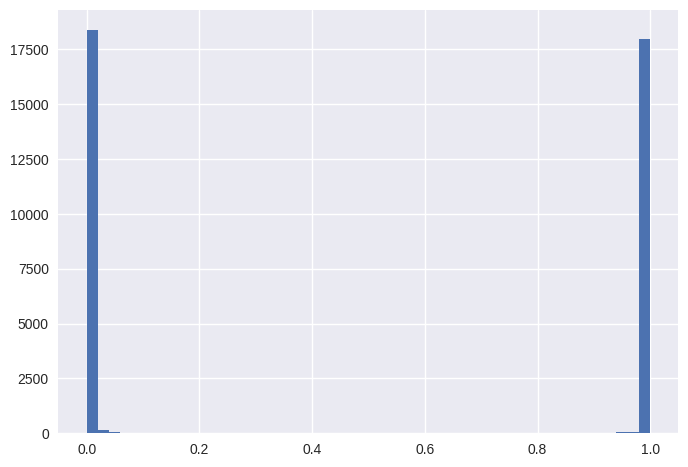

In [ ]:
plt.hist(pred, bins = 50)
plt.show()

## Out-Sample Prediction and Forward Testing

In [ ]:
test_s = (test - mu) / std # standardization of test set features (with train set parameters!!!)

In [ ]:
model.evaluate(test_s[cols], test["dir"])

593/593 [==============================] - 1s 2ms/step - loss: 0.0016 - accuracy: 0.9999


[0.0016226100269705057, 0.9998944997787476]

In [ ]:
pred = model.predict(test_s[cols])
pred

593/593 [==============================] - 1s 2ms/step


array([[0.0000000e+00],
       [1.0000000e+00],
       [2.9533455e-16],
       ...,
       [2.1837214e-19],
       [5.5653565e-10],
       [1.0000000e+00]], dtype=float32)

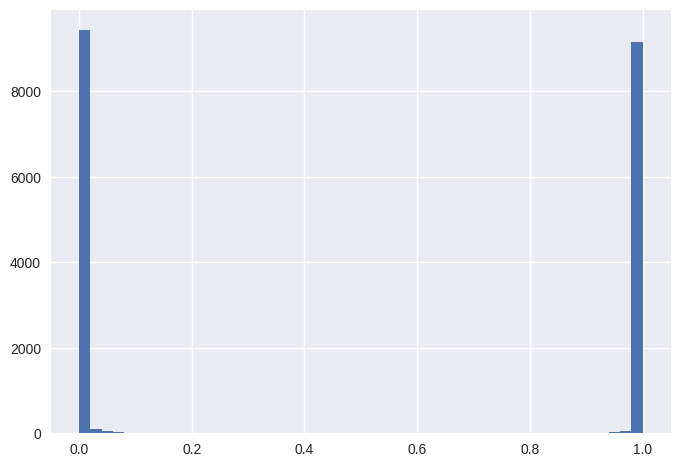

In [ ]:
plt.hist(pred, bins = 50);

In [ ]:
test["proba"] = model.predict(test_s[cols])

593/593 [==============================] - 1s 2ms/step


In [ ]:
test["position"] = np.where(test.proba < 0.47, -1, np.nan) # 1. short where proba < 0.47

In [ ]:
test["position"] = np.where(test.proba > 0.53, 1, test.position) # 2. long where proba > 0.53

In [ ]:
test.index = test.index.tz_localize("UTC")
test["NYTime"] = test.index.tz_convert("America/New_York")
test["hour"] = test.NYTime.dt.hour

In [ ]:
test["position"] = np.where(~test.hour.between(2, 12), 0, test.position) # 3. neutral in non-busy hours

In [ ]:
test["position"] = test.position.ffill().fillna(0) # 4. in all other cases: hold position

In [ ]:
test.position.value_counts(dropna = False)

0.00000     10258
-1.00000     4431
1.00000      4271
Name: position, dtype: int64

In [ ]:
test["strategy"] = test["position"] * test["returns"]

In [ ]:
test["creturns"] = test["returns"].cumsum().apply(np.exp)
test["cstrategy"] = test["strategy"].cumsum().apply(np.exp)

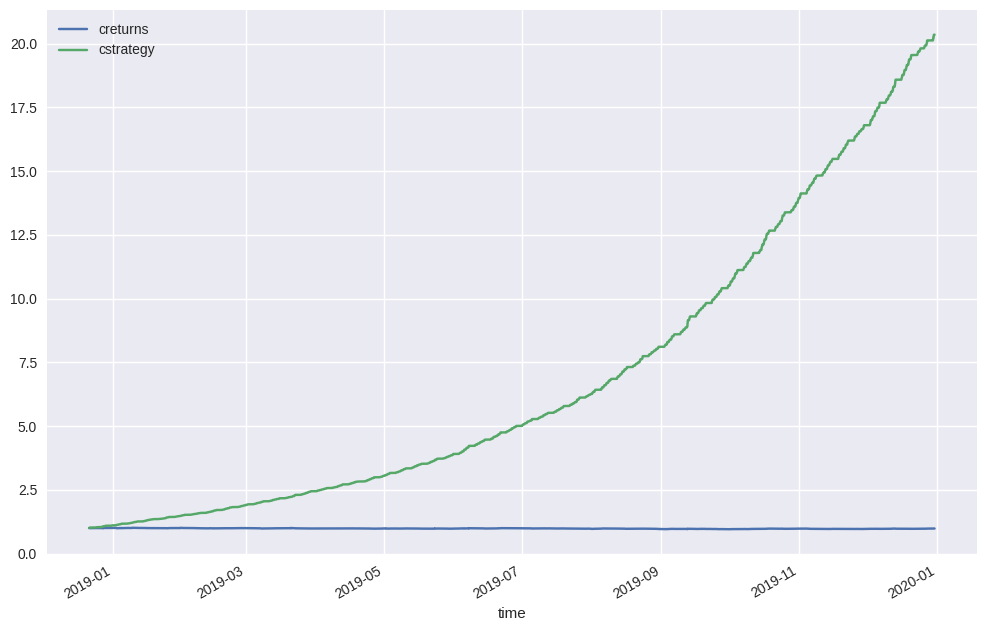

In [ ]:
test[["creturns", "cstrategy"]].plot(figsize = (12, 8))
plt.show()

In [ ]:
ptc = 0.000059

In [ ]:
test["trades"] = test.position.diff().abs()

In [ ]:
test.trades.value_counts()

0.00000    14095
2.00000     4337
1.00000      527
Name: trades, dtype: int64

In [ ]:
test["strategy_net"] = test.strategy - test.trades * ptc

In [ ]:
test["cstrategy_net"] = test["strategy_net"].cumsum().apply(np.exp)

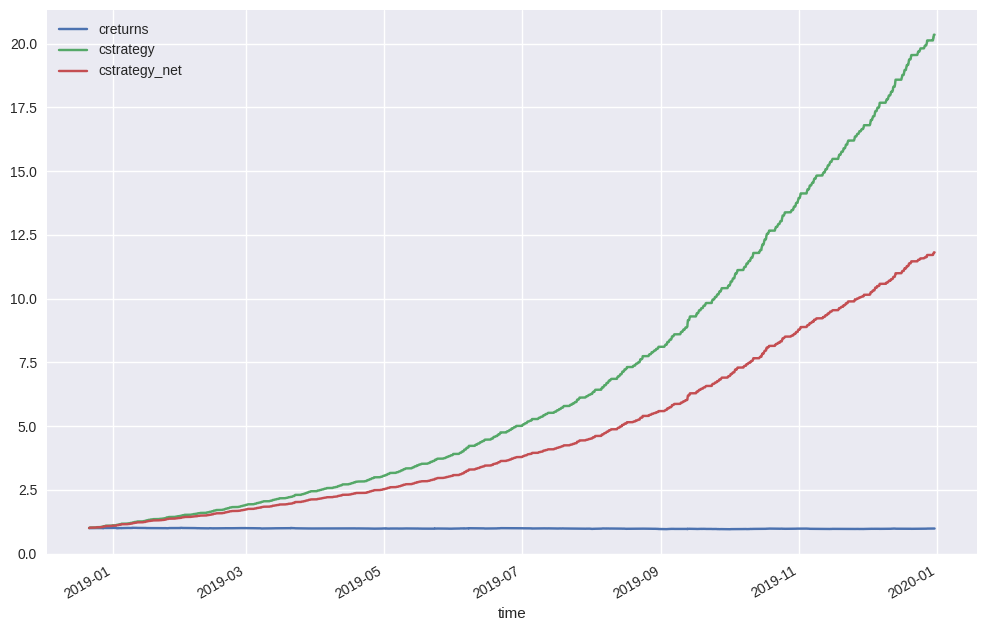

In [ ]:
test[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12, 8))
plt.show()

## Saving Model and Parameters

In [ ]:
model.save("DNN_model")

2023-06-01 22:05:45.083756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2023-06-01 22:05:45.109238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2023-06-01 22:05:45.131540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2023-06-01 22:05:45

INFO:tensorflow:Assets written to: DNN_model/assets


In [ ]:
params = {"mu":mu, "std":std}

In [ ]:
pickle.dump(params, open("params.pkl", "wb"))

## Implementation

__Loading Model and Parameters__

In [ ]:
# Loading the model
model = keras.models.load_model("DNN_model")

In [ ]:
params = pickle.load(open("params.pkl", "rb"))
mu = params["mu"]
std = params["std"]

__[FXCM] Implementation__

In [ ]:
api = fxcmpy.fxcmpy(config_file= "FXCM.cfg")

In [ ]:
col = ["tradeId", "amountK", "currency", "grossPL", "isBuy"]

In [ ]:
class DNNTrader():
    
    def __init__(self, instrument, bar_length, window, lags, model, mu, std, units, cols):
        self.instrument = instrument
        self.bar_length = pd.to_timedelta(bar_length) 
        self.tick_data = None
        self.raw_data = None
        self.data = None 
        self.ticks = 0
        self.last_bar = None  
        self.units = units
        self.position = 0
        self.col = cols
        
        self.isFirst = True
        
        #*****************add strategy-specific attributes here******************
        self.window = window
        self.lags = lags
        self.model = model
        self.mu = mu
        self.std = std
        #************************************************************************        
    
    def get_most_recent(self, period = "m1", number = 10000):
        while True:  
            time.sleep(5)
            df = api.get_candles(self.instrument, number = number, period = period, columns = ["bidclose", "askclose"])
            df[self.instrument] = (df.bidclose + df.askclose) / 2
            df = df[self.instrument].to_frame()
            df = df.resample(self.bar_length, label = "right").last().dropna().iloc[:-1]
            self.raw_data = df.copy()
            self.last_bar = self.raw_data.index[-1]
            if pd.to_datetime(datetime.utcnow()) - self.last_bar < self.bar_length:
                self.start_time = pd.to_datetime(datetime.utcnow()) # NEW -> Start Time of Trading Session
                break
    
    def get_tick_data(self, data, dataframe):
        
        self.ticks += 1
        print(self.ticks, end = " ", flush = True)
        
        recent_tick = pd.to_datetime(data["Updated"], unit = "ms")
        
        if recent_tick - self.last_bar > self.bar_length:
            self.tick_data = dataframe.loc[self.last_bar:, ["Bid", "Ask"]]
            self.tick_data[self.instrument] = (self.tick_data.Ask + self.tick_data.Bid)/2
            self.tick_data = self.tick_data[self.instrument].to_frame()
            self.resample_and_join()
            self.define_strategy() 
            self.execute_trades()
            
    def resample_and_join(self):
        self.raw_data = self.raw_data.append(self.tick_data.resample(self.bar_length, 
                                                             label="right").last().ffill().iloc[:-1])
        self.last_bar = self.raw_data.index[-1]  
        
    def define_strategy(self): # "strategy-specific"
        df = self.raw_data.copy()
    
        #******************** define your strategy here ************************
        df = df.append(self.tick_data.iloc[-1]) # append latest tick (== open price of current bar)
    
        df["returns"] = np.log(df[self.instrument] / df[self.instrument].shift())
        df['Ask_Dir'] = np.where(df['returns'].shift(-1) > df.returns, 1, 0)
        df['SMA'] = abstract.SMA(df['returns'], timeperiod=12)
        df['SMA_Dir'] = np.where(df['SMA'].shift(-1) > df.SMA, 1, 0)
        df['RSI'] = abstract.RSI(df['returns'], timeperiod=12)
        df['RSI_Dir'] = np.where(df['RSI'].shift(-1) > df.RSI, 1, 0)
        df['fastk'], df['fastd'] = abstract.STOCHRSI(df["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
        df['fastk_Dir'] = np.where(df['fastk'].shift(-1) > df.fastk, 1, 0)
        df['fastd_Dir'] = np.where(df['fastd'].shift(-1) > df.fastd, 1, 0)    
        #df.dropna(inplace = True)
        self.cols = ['returns', 'Ask_Dir', 'SMA', 'SMA_Dir', 'RSI', 'RSI_Dir', 'fastk', 'fastd', 'fastk_Dir', 'fastd_Dir']
        # standardization
        df_s = (df - self.mu) / self.std
        # predict

        

        df["proba"] = self.model.predict(df_s[self.cols])
        
        #determine positions
        df = df.loc[self.start_time:].copy() # starting with first live_stream bar (removing historical bars)
        df["position"] = np.where(df.proba < 0.47, -1, np.nan)
        df["position"] = np.where(df.proba > 0.53, 1, df.position)
        df["position"] = df.position.ffill().fillna(0) # start with neutral position if no strong signal
        #***********************************************************************
        self.proba = df["position"].iloc[-1]
        lastRow = df.iloc[-1]
        
        if self.isFirst:
            df.to_csv('data.csv', header=True)
            self.isFirst = False
        else:
            lastRow.to_csv('data.csv', mode='a', index=True, header=True)
        
        self.value = df[self.instrument].iloc[-1]
        #df = df[self.col]
        self.data = df.copy()
        
    def execute_trades(self):
        print('___________________')
        print(self.proba )
        print(self.value )
        print('___________________')

    def report_trade(self, order, going):
        time = order.get_time()
        units = api.get_open_positions().amountK.iloc[-1]
        price = api.get_open_positions().open.iloc[-1]
        unreal_pl = api.get_open_positions().grossPL.sum()
        print("\n" + 100* "-")
        print("{} | {}".format(time, going))
        print("{} | units = {} | price = {} | Unreal. P&L = {}".format(time, units, price, unreal_pl))
        print(100 * "-" + "\n")

In [ ]:
trader = DNNTrader("EUR/USD", bar_length = "10min", 
                   window = 50, lags = 5, model = model, mu = mu, std = std, units = 100, cols=cols)

In [ ]:
trader.get_most_recent()
api.subscribe_market_data(trader.instrument, (trader.get_tick_data, ))

In [ ]:
'''
api.unsubscribe_market_data(trader.instrument)
if len(api.get_open_positions()) != 0: # if we have final open position(s) (netting and hedging)
    api.close_all_for_symbol(trader.instrument)
    print(2*"\n" + "{} | GOING NEUTRAL".format(str(datetime.utcnow())) + "\n")
    time.sleep(20)
    print(api.get_closed_positions_summary()[col])
    trader.position = 0
'''

'\napi.unsubscribe_market_data(trader.instrument)\nif len(api.get_open_positions()) != 0: # if we have final open position(s) (netting and hedging)\n    api.close_all_for_symbol(trader.instrument)\n    print(2*"\n" + "{} | GOING NEUTRAL".format(str(datetime.utcnow())) + "\n")\n    time.sleep(20)\n    print(api.get_closed_positions_summary()[col])\n    trader.position = 0\n'

In [ ]:
#trader.data

In [ ]:
cols

Index(['returns', 'Ask_Dir', 'SMA', 'SMA_Dir', 'RSI', 'RSI_Dir', 'fastk',
       'fastd', 'fastk_Dir', 'fastd_Dir'],
      dtype='object')

32/32 [==============================] - 0s 2ms/step1 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
___________________
-1.0
1.076085
___________________
32/32 [==============================] - 0s 2ms/step2 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 2